https://stackoverflow.com/questions/53838696/problems-regarding-pyomo-provided-math-functions

https://stackoverflow.com/questions/70048818/optimization-of-a-battery-storage-with-pyomo

https://gitlab.com/diw-evu/emobpy/emobpy/-/blob/master/emobpy/data/evspecs.json

https://github.com/L-Strobel/jointAnalysisCharging/tree/main/chargingmodel

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import math
import pyomo.environ as pyo 
import pyomo.opt as opt
from IPython.display import clear_output
from pyomo.opt import SolverFactory
import random
from pandas import Timestamp
import pickle
from varname import nameof
import matplotlib.dates as mdates


In [78]:
if get_dir_size(os.path.join(data_path, "ged_db")) > 0.04:
    transtion_files(os.path.join(data_path, "ged_db"))

In [ ]:
DB_c.update()

In [ ]:
DB_c.loadfiles()

In [5]:
c_names = list(DB_c.db.keys()) 

NameError: name 'DB_c' is not defined

In [ ]:
DB_a = DataBase(os.path.join(data_path, "availability", "0"))
DB_a.update()

## Functions

ga.set_scenario(station_distribution)
ga.run()
soc_init:0.5 --> soc_end:1.0

In [123]:
##Wieviele Ladevorgägne / Tag ca.? 

## Emobpy input 

In [124]:
#emobpy import
processing_path = os.getcwd()
os.chdir("../emobpy")
data_path = os.getcwd()
os.chdir(processing_path)

consumption_ts = pd.read_pickle(os.path.join(data_path, "consumption"))
availability_ts = pd.read_pickle(os.path.join(data_path, "availability"))
car_properties_raw = pd.read_pickle(os.path.join(data_path, "properties"))
car_properties_raw = car_properties_raw.iloc[:,:80]
soc_min = 0

In [125]:
#consumption ts
#consumption = pd.DataFrame(data = np.array([[0, 0.5], [0, 0.5], [0.5, 0], [0.5, 0]]), columns = ["c_1[kW]", "c_2[kW]"])
consumption_raw = consumption_ts.iloc[:,:80]

In [126]:
#power availability ts
#power = pd.DataFrame(pd.DataFrame(data = np.array([[1, 0], [1, 0], [0, 1], [0, 1]]), columns = ["p_1 [kW]", "p_2 [kW]"]))
power_raw = availability_ts.iloc[:,:80]

neg_power_magnitude_raw = power_raw

In [127]:
#set datetime indexes 
consumption_raw.index = consumption_ts.index[:len(consumption_raw.index)]
index = consumption_raw.index

power_raw.index = index
neg_power_magnitude_raw.index = index

In [128]:
def plot_step(df):
    df_ = df.copy()
    
    if type(df.index[0]) == int:
        df_.loc[df_.index[-1]+1,:] = df_.iloc[-1,:]
        print("a")
    else:
        df_.loc[str(pd.Timestamp(df_.index[-1] ) + 
                    pd.Timedelta(pd.infer_freq(index))),:
               ] = df_.iloc[-1,:]
        
    df_.index = pd.to_datetime(df_.index)
    
    fig, ax = plt.subplots(2)
    time_constrained=df_[df_.index.date <= df_.index[0].date()]
    x = time_constrained.index
    ax[0].step(x=x, y = time_constrained.iloc[:,2], where = "post")
    ax[1].step(x=x, y = time_constrained.sum(1).to_frame().rename(columns={0:"aggregated"}), where = "post")
    for i in [0,1]:
        ax[i].xaxis.set_major_locator(mdates.HourLocator())
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        ax[i].set_ylabel("kWh/15min")
        ax[i].set_ylim(bottom=0)
        
    fig.tight_layout()
    plt.show()


In [ ]:
consumption_raw.sum(1).resample("3w").mean().plot()

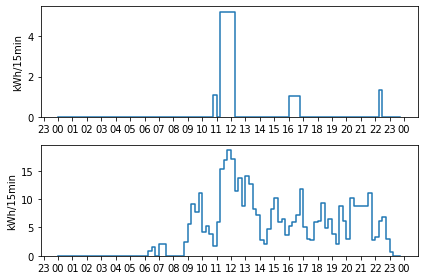

In [129]:
plot_step(consumption_raw)

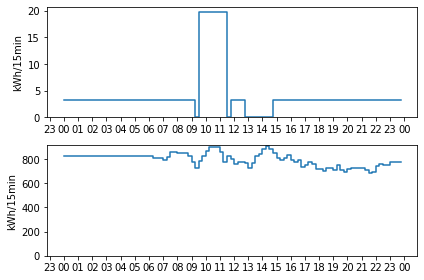

In [130]:
plot_step(power_raw)

In [131]:
step_duration = int(pd.infer_freq(index)[:-1]) / 60  #parts of an hour

soc_min = 0 #0%

# EES-transformation: Generating uncontrolled and latest charging ts

In [132]:
##level= [0, 2]
##level_ = [0, 1]

##bidirectional means new decision variable --> new efficiencies! 

#set same names for columns
power_raw.columns = consumption_raw.columns
neg_power_magnitude_raw.columns = consumption_raw.columns
car_properties_raw.columns = consumption_raw.columns

In [459]:
solution_dict = {}
ees_constraints= pd.DataFrame()

for c in consumption_raw.columns.unique():
    
    for i, car in enumerate(consumption_raw[c].columns):
        consumption= consumption_raw[c].iloc[:,i]
        power= power_raw[c].iloc[:,i]
        neg_power_magnitude= neg_power_magnitude_raw[c].iloc[:,i]
        car_properties= car_properties_raw[c].iloc[:,i]
        
        solution_dict[car+str(i)] = {}
        level_0 = car_properties["soc_init"]
        level_T = car_properties.loc["soc_end"]
        battery_capacity = car_properties.loc["battery_capacity"]

        for model_type in ["m_late", "m_early"]:

            #Initialize model
            m = pyo.ConcreteModel()
            #initialize sets
            m.t = pyo.Set(initialize = index, ordered = True)

            #Initialize parameter
            m.consumption = pyo.Param(m.t, initialize=consumption.to_dict())
            m.power = pyo.Param(m.t, initialize=power.to_dict()) 
            m.neg_power = pyo.Param(m.t, initialize=neg_power_magnitude.to_dict()) 

            #Initialize variables
            m.CHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
            m.DISCHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
            m.LEVEL = pyo.Var(m.t, within = pyo.NonNegativeReals, 
                              bounds = (soc_min*battery_capacity,battery_capacity))

            #level constraints
            def recursive_level(m, t):
                if t == index[0]:
                    return m.LEVEL[t] == level_0 + (m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )#*step_duration
                else:    
                    return m.LEVEL[t] == m.LEVEL[pd.Timestamp(t) - 
                                                     pd.Timedelta(pd.infer_freq(index))] + (
                        m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )#*step_duration   
            m.Recursive_level = pyo.Constraint(m.t, rule = recursive_level)

            def final_level(m, t):
                if t == index[-1]:
                    return m.LEVEL[t] == level_T
                else: 
                    return pyo.Constraint.Skip
            m.Final_level = pyo.Constraint(m.t, rule=final_level)

            #bidirectional charging 
            def neg_power_min(m, t):
                return m.DISCHARGE[t] <= m.neg_power[t]
            m.Neg_power_min_restriction = pyo.Constraint(m.t, rule=neg_power_min)

            def power_max(m, t):
                return m.CHARGE[t] <= m.power[t]   
            m.Power_max_restriction = pyo.Constraint(m.t, rule=power_max)

            # objective function late
            def battery_level_sum(m, t): 
                return sum(m.LEVEL[t] for t in m.t) 

            if model_type == "m_late":
                sense = pyo.minimize
            elif model_type == "m_early":
                sense = pyo.maximize     
            m.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

            #find solver
            solvername='glpk'

            #prepare solver
            optimizer = opt.SolverFactory(solvername) 
            solved_model = optimizer.solve(m)        

            if pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0][-1]== None:
                level_series = pd.concat([
                    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                    pd.Series(level_0, index=index)
                ], axis=0)
                charge_df = pd.DataFrame(0, index=index, columns = [car])
                discharge_df = pd.DataFrame(0, index=index, columns = [car])
            else: 
                level_series = pd.concat([
                    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                    pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0]
                ], axis=0)
                charge_df = pd.DataFrame.from_dict(m.CHARGE.extract_values(), orient='index', columns = [car])
                discharge_df = pd.DataFrame.from_dict(m.DISCHARGE.extract_values(), orient='index', columns = [car])
            
            #store data in dictionary
            solution_dict[car+str(i)][model_type] = {}
            solution_dict[car+str(i)][model_type]["level"] = level_series
            solution_dict[car+str(i)][model_type]["charge"] = charge_df
            solution_dict[car+str(i)][model_type]["discharge"] = discharge_df
            level_index = solution_dict[car+str(i)][model_type]["level"].index
            if model_type == "m_early":
                solution_dict[car+str(i)]["level_differences"] = (solution_dict[car+str(i)]["m_late"]["level"] - 
                                                           solution_dict[car+str(i)]["m_early"]["level"]).to_frame().rename(columns={0:car})
                ees_constraints= pd.concat([ees_constraints, solution_dict[car+str(i)]["level_differences"]], axis = 1)

solution_dict = {}
ees_constraints= pd.DataFrame()
##zweite for schleife
for i, car in enumerate(consumption.columns): 
    car = i
    solution_dict[car] = {}
    level_0 = car_properties.loc["soc_init"][car] ##level[i]
    level_T = car_properties.loc["soc_end"][car] ##level_[i]
    battery_capacity = car_properties.loc["battery_capacity"][car] ##2
    
    for model_type in ["m_late", "m_early"]:
        
        #Initialize model
        m = pyo.ConcreteModel()
        #initialize sets
        m.t = pyo.Set(initialize = index, ordered = True)
        
        #Initialize parameter
        m.consumption = pyo.Param(m.t, initialize=consumption[car].to_dict())
        m.power = pyo.Param(m.t, initialize=power.loc[:,car].to_dict()) 
        m.neg_power = pyo.Param(m.t, initialize=neg_power_magnitude.loc[:,car].to_dict()) 

        #Initialize variables
        m.CHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
        m.DISCHARGE = pyo.Var(m.t, within = pyo.NonNegativeReals)
        m.LEVEL = pyo.Var(m.t, within = pyo.NonNegativeReals, 
                          bounds = (soc_min*battery_capacity,battery_capacity))

        #level constraints
        def recursive_level(m, t):
            if t == index[0]:
                return m.LEVEL[t] == level_0 + (m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )#*step_duration
            else:    
                return m.LEVEL[t] == m.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m.CHARGE[t] - m.DISCHARGE[t] - m.consumption[t] )#*step_duration   
        m.Recursive_level = pyo.Constraint(m.t, rule = recursive_level)

        def final_level(m, t):
            if t == index[-1]:
                return m.LEVEL[t] == level_T
            else: 
                return pyo.Constraint.Skip
        m.Final_level = pyo.Constraint(m.t, rule=final_level)

        #bidirectional charging 
        def neg_power_min(m, t):
            return m.DISCHARGE[t] <= m.neg_power[t]
        m.Neg_power_min_restriction = pyo.Constraint(m.t, rule=neg_power_min)
        
        def power_max(m, t):
            return m.CHARGE[t] <= m.power[t]   
        m.Power_max_restriction = pyo.Constraint(m.t, rule=power_max)
        
        # objective function late
        def battery_level_sum(m, t): 
            return sum(m.LEVEL[t] for t in m.t) 
        
        if model_type == "m_late":
            sense = pyo.minimize
        elif model_type == "m_early":
            sense = pyo.maximize     
        m.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)
        
        #find solver
        solvername='glpk'
        
        #prepare solver
        optimizer = opt.SolverFactory(solvername) 
        solved_model = optimizer.solve(m)        
        
        if pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0][-1]== None:
            level_series = pd.concat([
                pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                pd.Series(level_0, index=index)
            ], axis=0)
            charge_df = pd.DataFrame(0, index=index, columns = [car])
            discharge_df = pd.DataFrame(0, index=index, columns = [car])
        else: 
            level_series = pd.concat([
                pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]),
                pd.DataFrame.from_dict(m.LEVEL.extract_values(), orient='index')[0]
            ], axis=0)
            charge_df = pd.DataFrame.from_dict(m.CHARGE.extract_values(), orient='index', columns = [car])
            discharge_df = pd.DataFrame.from_dict(m.DISCHARGE.extract_values(), orient='index', columns = [car])
        #store data in dictionary
        solution_dict[car][model_type] = {}
        solution_dict[car][model_type]["level"] = level_series
        solution_dict[car][model_type]["charge"] = charge_df
        solution_dict[car][model_type]["discharge"] = discharge_df
        level_index = solution_dict[car][model_type]["level"].index
        if model_type == "m_early":
            solution_dict[car]["level_differences"] = (solution_dict[car]["m_late"]["level"] - 
                                                       solution_dict[car]["m_early"]["level"]).to_frame().rename(columns={0:car})
            ees_constraints= pd.concat([ees_constraints, solution_dict[car]["level_differences"]], axis = 1)

In [460]:
#plausibility check: energy charged is the same for both scenarios (if battery capacity is exceeded)
solution_dict[car+str(i)]["m_early"]["charge"].sum() - solution_dict[car+str(i)]["m_early"]["discharge"].sum() - solution_dict[car+str(i)]["m_late"]["charge"].sum() + solution_dict[car+str(i)]["m_late"]["discharge"].sum()

KIA/e-Niro_64_kWh/2019    0
dtype: int64

In [461]:
#prepare variables and functions for optimization 
def plot_results(variable, car):
    observations = 200
    if variable == "charge":
        x = index[:observations]
        fig, ax = plt.subplots(4)
        ax[0].step(x, solution_dict[car]["m_late"]["charge"][:observations],  where = "mid")
        ax[0].set_title("late_charging")
        
        ax[1].step(index, solution_dict[car]["m_early"]["charge"][:observations],  where = "mid")
        ax[1].set_title("uncontrolled_charging")
        
        ax[2].step(x, solution_dict[car]["m_late"]["discharge"][:observations],  where = "mid")
        ax[2].set_title("late_discharging")
        
        ax[3].step(x, solution_dict[car]["m_early"]["discharge"][:observations],  where = "mid")
        ax[3].set_title("uncontrolled_discharging")
        for i in range(0,4):
            ax[i].set_ylabel("kW")
            ax[i].xaxis.set_major_locator(mdates.DayLocator())
            ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
            ax[i].set_ylabel("kW")
    else: 
        observations = observations + 1
        x = level_index[:(observations)]
        fig, ax = plt.subplots(3)
        ax[0].plot(x, solution_dict[car]["m_late"]["level"][:observations])
        ax[0].set_ylim(0, solution_dict[car]["m_early"]["level"].max())
        ax[0].set_title("late_level")
        
        ax[1].plot(x, solution_dict[car]["m_early"]["level"][:observations])
        ax[1].set_ylim(0, solution_dict[car]["m_early"]["level"].max())
        ax[1].set_title("uncontrolled_level")
        
        ax[2].plot(x, solution_dict[car]["level_differences"][:observations])
        ax[2].set_title("level_solution differences")
        ax[2].set_ylim(-solution_dict[car]["m_early"]["level"].max(),)
        
        for i in range(0,3):
            ax[i].set_ylabel("kWh")
            ax[i].xaxis.set_major_locator(mdates.DayLocator())
            ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d'))
            ax[i].set_ylabel("kW")

    plt.tight_layout()
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (35064,) and (200, 1)

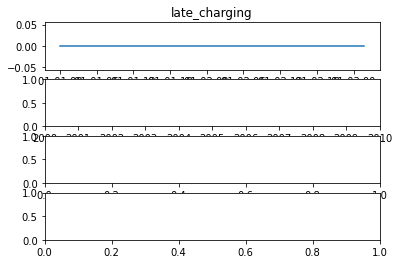

In [462]:
plot_results("charge", car+str(i)) 
plot_results("level", car+str(i))

## Processing EES-profiles: Aggregation

In [137]:
ees_constraints.index = level_index

In [138]:
#aggregation
ees_constraints_aggergated = ees_constraints.sum(1)
naive_constraints_aggergated = pd.Series(data=sum(
    car_properties_raw.loc["battery_capacity"]), index=level_index)
aggregated_max_battery = naive_constraints_aggergated.sum()

<AxesSubplot:>

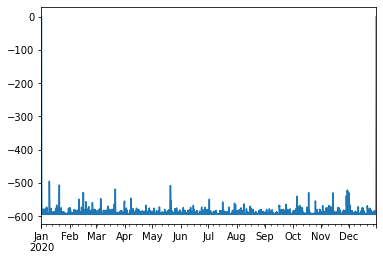

In [139]:
ees_constraints_aggergated.plot()

<AxesSubplot:>

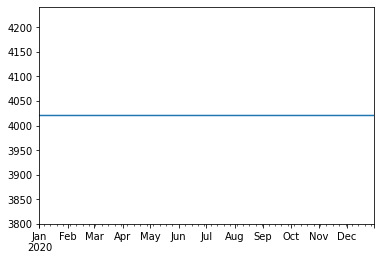

In [140]:
naive_constraints_aggergated.plot()

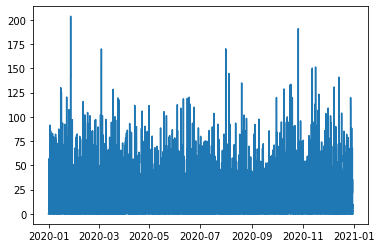

In [141]:
consumption_aggregated =  pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), consumption_raw.sum(1)
              ], axis = 0)
plt.step(consumption_aggregated.iloc[1:].resample("h").sum().index, consumption_aggregated.iloc[1:].resample("h").sum())

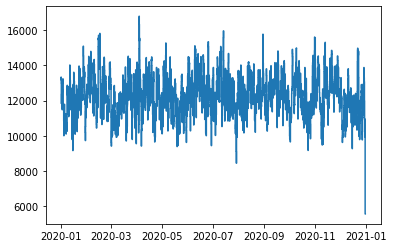

In [142]:
power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), power_raw.sum(1)
              ], axis = 0)
plt.step(power_aggregated.iloc[1:].resample("4h").sum().index, power_aggregated.iloc[1:].resample("4h").sum())

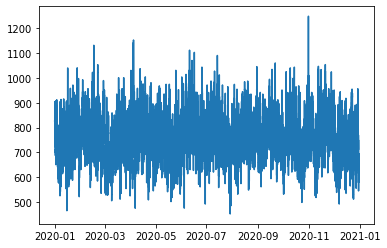

In [143]:
neg_power_aggregated = pd.concat([
    pd.Series(0, index=[index[0]-pd.Timedelta(pd.infer_freq(index))]), neg_power_magnitude_raw.sum(1)
              ], axis = 0)
plt.step(neg_power_aggregated.iloc[1:].index, neg_power_aggregated.iloc[1:]) 

## Aggregated Optimization

In [164]:
#!pip install pickle5

     |████████████████████████████████| 125 kB 3.2 MB/s eta 0:00:01


In [165]:
import pickle5 as pickle

In [289]:
#create random prices [cent / kWh] 
#prices = pd.Series(data=[random.uniform(0.2, 0.5) for t in level_index], index=level_index)
#prices.resample("d").mean().plot()

with open("prices_2020", "rb") as fh:
    data = pickle.load(fh)

In [341]:
prices = data

prices = prices[prices.index >= "2019-12-31 22:45:00+01:00"]

prices.index =  prices.index.map(
    lambda x: pd.to_datetime(x.replace(tzinfo=None))
)
prices = prices[prices.index.drop_duplicates(keep=False)]
prices = prices.reindex(consumption_aggregated.index, method = "ffill") 
prices = prices / (10**3) # €/MWh --> €/kWh

<AxesSubplot:>

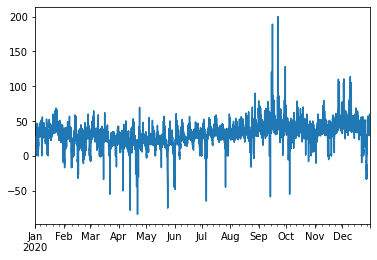

In [342]:
prices.plot()

In [438]:
def plot_aggregated_results(model_type):
    obversvations = 200
    x = level_index[:obversvations]
    fig, ax = plt.subplots(3)
    ax[0].step(x, 
               pyo.value(agg_solutions[model_type]["CHARGE"].values[:obversvations]), where="pre")
    ax[0].set_title("{}_charging".format(model_type))
    
    
    ax[1].step(x, 
               pyo.value(agg_solutions[model_type]["DISCHARGE"].values[:obversvations]), where="pre")
    ax[1].set_title("{}_discharging".format(model_type))
    
    
    ax[2].plot(x, 
               pyo.value(agg_solutions[model_type]["LEVEL"].values[:obversvations]))
    ax[2].set_title("{}_level".format(model_type))
    ax[2].set_ylabel("kWh")
    
    
    for i in range(0,2):
        ax[i].set_ylabel("kWh/15min")
        ax[i].set_xticks(pd.date_range(x[0], x[-1], freq="D"))
        #plt.set_xticklabels(rotation= 45)
        plt.xticks(rotation= 45)
    fig.autofmt_xdate(rotation=45)


    plt.tight_layout()
    plt.show()

Assumptions: 

- same price for (DIS)CHARGE
- 𝑓𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 = sum(ees_charging_costs)
- controlled costs = uncontrolled_costs - 𝑙𝑒𝑥𝑖𝑏𝑖𝑙𝑖𝑡𝑦 𝑟𝑒𝑣𝑒𝑛𝑢𝑒𝑠 

In [344]:
agg_solutions = {}
level_0_agg = car_properties_raw.loc["soc_init"].sum()
level_T_agg = car_properties_raw.loc["soc_end"].sum()

for model_type in ["naive", "ees"]:

    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = level_index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    #m_agg.max_battery_cap = pyo.Param(m_agg.t, initialize=naive_constraints_aggergated.to_dict()) 
    
    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.Reals)
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_PHYS = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE_WAIT = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)

    if model_type == "ees":
        m_agg.ees_min = pyo.Param(m_agg.t, initialize=ees_constraints_aggergated.to_dict()) 
        m_agg.DISCHARGE_WAIT = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)

    #recursive level
        def recursive_level(m, t):
            if t == level_index[0]:
                return m_agg.LEVEL[t] == (m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t])#*step_duration   
            else:
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m_agg.CHARGE[t] - m_agg.DISCHARGE_WAIT[t] - m_agg.DISCHARGE_PHYS[t]) * step_duration   
    else:
        def recursive_level(m, t):
            if t == level_index[0]: 
                return m_agg.LEVEL[t] == level_0_agg + (m_agg.CHARGE[t]- m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t] )#*step_duration   
            else:
                return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                                 pd.Timedelta(pd.infer_freq(index))] + (
                    m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE_PHYS[t])# * step_duration   
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)

    def level_constraint(m, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] >= m_agg.ees_min[t] 
        else:
            return m_agg.LEVEL[t] <= aggregated_max_battery
    m_agg.Level_constraint = pyo.Constraint(m_agg.t, rule=level_constraint)
    
    def level_constraint_2(m, t):
        if model_type=="ees":
            return m_agg.LEVEL[t] <= 0
        else:
            return m_agg.LEVEL[t] >= soc_min*aggregated_max_battery#m_agg.max_battery_cap[t]
    m_agg.Level_constraint_2 = pyo.Constraint(m_agg.t, rule=level_constraint_2)
    
    def power_charge_max(m, t):
        return m_agg.CHARGE[t] <= m_agg.power[t]   
    m_agg.Power_charge_max = pyo.Constraint(m_agg.t, rule=power_charge_max)

    def power_discharge_consumption_max(m, t):
        return m_agg.DISCHARGE_WAIT[t] <= m_agg.power[t]     
    m_agg.Power_discharge_consumption_max = pyo.Constraint(m_agg.t, rule=power_discharge_consumption_max)
    
    def power_discharge_phys_max(m, t):
        return m_agg.DISCHARGE_PHYS[t] <= m_agg.neg_power[t] 
    m_agg.Power_discharge_phys_max = pyo.Constraint(m_agg.t, rule=power_discharge_phys_max)

    # objective function
    if model_type == "ees":
        def min_ees_costs(m): 
            return sum(
                (m_agg.CHARGE[t]-m_agg.DISCHARGE_WAIT[t]-m_agg.DISCHARGE_PHYS[t]
                ) * prices[t] #step_duration *
                for t in m.t
            ) 
        m_agg.Obj_min_ees_costs = pyo.Objective(rule=min_ees_costs, sense=pyo.minimize)
    else:
        def min_naive_costs(m): 
            return sum(
                (m_agg.CHARGE[t]-m_agg.DISCHARGE_PHYS[t]) * prices[t] #step_duration *
                for t in m.t
            ) 
        m_agg.Obj_min_naive_costs = pyo.Objective(rule=min_naive_costs, sense=pyo.minimize)
        
    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg)        
    
    agg_solutions[model_type] = {}
    agg_solutions[model_type]["costs"] = solved_model['Problem']()['Lower bound']
    agg_solutions[model_type]["CHARGE"] = pd.DataFrame.from_dict(m_agg.CHARGE.extract_values(), orient='index', columns = [model_type])
    agg_solutions[model_type]["DISCHARGE"] = pd.DataFrame.from_dict(m_agg.DISCHARGE_WAIT.extract_values(), orient='index', columns = [model_type]) + pd.DataFrame.from_dict(m_agg.DISCHARGE_PHYS.extract_values(), orient='index', columns = [model_type])
    agg_solutions[model_type]["LEVEL"] = pd.DataFrame.from_dict(m_agg.LEVEL.extract_values(), orient='index', columns = [model_type])

    (type=<class 'pyomo.core.base.var.IndexedVar'>) on block unknown with a
    new Component (type=<class 'pyomo.core.base.var.IndexedVar'>). This is
    usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().


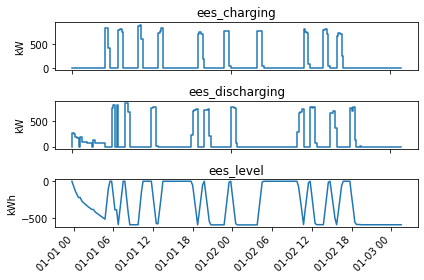

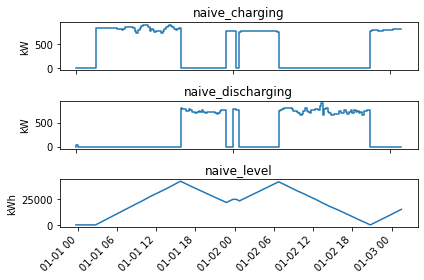

In [440]:
plot_aggregated_results("ees")
plot_aggregated_results("naive")

# Analysis

## How big is the aggregation error? 

In [357]:
agg_overest_solutions = {}

for model_type in ["m_early_agg", "m_late_agg"]:
    #Initialize model
    m_agg = pyo.ConcreteModel()

    #initialize sets
    m_agg.t = pyo.Set(initialize = level_index, ordered = True)

    m_agg.consumption_aggregated = pyo.Param(m_agg.t, initialize=consumption_aggregated.to_dict())
    m_agg.power = pyo.Param(m_agg.t, initialize=power_aggregated.to_dict()) 
    m_agg.neg_power = pyo.Param(m_agg.t, initialize=neg_power_aggregated.to_dict()) 

    m_agg.LEVEL = pyo.Var(m_agg.t, within = pyo.NonNegativeReals, bounds=(
        soc_min*aggregated_max_battery, aggregated_max_battery))
    m_agg.CHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)
    m_agg.DISCHARGE = pyo.Var(m_agg.t, within = pyo.NonNegativeReals)

    #level constraints
    def recursive_level(m_agg, t):
        if t == level_index[0]:
            return m_agg.LEVEL[t] == level_0_agg + m_agg.CHARGE[t] - m_agg.consumption_aggregated[t]
        else:    
            return m_agg.LEVEL[t] == m_agg.LEVEL[pd.Timestamp(t) - 
                                             pd.Timedelta(pd.infer_freq(level_index))] + (
                m_agg.CHARGE[t] - m_agg.consumption_aggregated[t] - m_agg.DISCHARGE[t] )
    m_agg.Recursive_level = pyo.Constraint(m_agg.t, rule = recursive_level)

    #bidirectional charging 
    def neg_power_min(m, t):
        return m.DISCHARGE[t] <= m.neg_power[t]
    m_agg.Neg_power_min_restriction = pyo.Constraint(m_agg.t, rule=neg_power_min)

    def power_max(m, t):
        return m.CHARGE[t] <= m.power[t]   
    m_agg.Power_max_restriction = pyo.Constraint(m_agg.t, rule=power_max)
    
    def final_level(m_agg, t):
        if t == index[-1]:
            return m_agg.LEVEL[t] == level_T_agg
        else: 
            return pyo.Constraint.Skip
    m_agg.Final_level = pyo.Constraint(m_agg.t, rule=final_level)

    # objective function late
    def battery_level_sum(m_agg, t): 
        return sum(m_agg.LEVEL[t] for t in m_agg.t) 
    if model_type == "m_late_agg":
        sense = pyo.minimize
    elif model_type == "m_early_agg":
        sense = pyo.maximize     
    m_agg.Obj = pyo.Objective(rule=battery_level_sum, sense=sense)

    #find solver
    solvername='glpk'

    #prepare solver
    optimizer = opt.SolverFactory(solvername) 
    solved_model = optimizer.solve(m_agg)        

    #store data in dictionary
    agg_overest_solutions[model_type] = pd.DataFrame.from_dict(
        m_agg.LEVEL.extract_values(), orient='index')[0]

In [441]:
#overestimation in kWh how much could be shifted from uncontrolled charging?
overestimation = (
    (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()
    - ees_constraints.sum().sum()
)

print("theoretical overestimation: " + str(overestimation /  (agg_overest_solutions["m_late_agg"] - agg_overest_solutions["m_early_agg"]).sum()*100)+ " %")

theoretical overestimation: 99.99120336357112 %


## Cost

In [442]:
#controlled charging (physical) = uncontrolled charging - ees_dis + ee_scharging
uncontrolled_DIS_CHARGE_aggregated = pd.DataFrame(0, index=index, columns=["uncontrolled"])
physical_controlled_DIS_CHARGE_aggregated = pd.DataFrame(0, index=index, columns=["controlled_phys"])

for c in consumption_raw.columns.unique():
    for i, car in enumerate(consumption_raw[c]): 
        uncontrolled_DIS_CHARGE_aggregated["uncontrolled"] = (uncontrolled_DIS_CHARGE_aggregated["uncontrolled"] 
                                                              + solution_dict[car+str(i)]["m_early"]["charge"][car]) #- solution_dict[car]["m_early"]["discharge"][car]
        physical_controlled_DIS_CHARGE_aggregated["controlled_phys"] = (uncontrolled_DIS_CHARGE_aggregated["uncontrolled"] 
                                                      - agg_solutions["ees"]["DISCHARGE"]["ees"]
                                                      + agg_solutions["ees"]["CHARGE"]["ees"])
        controlled_DIS_CHARGE_naive = agg_solutions["naive"]["CHARGE"] - agg_solutions["naive"]["DISCHARGE"]

uncontrolled_costs = sum([uncontrolled_DIS_CHARGE_aggregated["uncontrolled"][i] * prices[i] for i in index])
controlled_costs_ees = sum([physical_controlled_DIS_CHARGE_aggregated["controlled_phys"][i] * prices[i] for i in index])
controlled_costs_naive = sum([controlled_DIS_CHARGE_naive["naive"][i] * prices[i] for i in index])

In [443]:
#plausibility check:
uncontrolled_DIS_CHARGE_aggregated["uncontrolled"].sum() - physical_controlled_DIS_CHARGE_aggregated["controlled_phys"] .sum()
round(controlled_costs_ees -(uncontrolled_costs + agg_solutions["ees"]["costs"]))
round(agg_solutions["naive"]["costs"] - controlled_costs_naive)

0

<AxesSubplot:xlabel='date'>

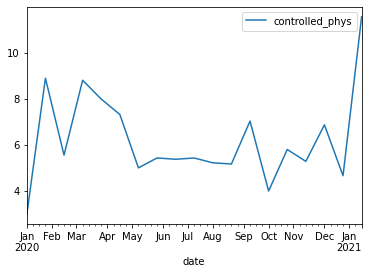

In [444]:
physical_controlled_DIS_CHARGE_aggregated.resample("3w").mean().plot(ylabel="kWh/15min")

In [ ]:
uncontrolled_DIS_CHARGE_aggregated.resample("3w").mean().plot(ylabel="kWh/15min")

<AxesSubplot:>

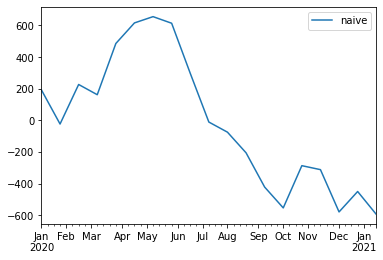

In [446]:
controlled_DIS_CHARGE_naive.resample("3w").mean().plot(ylabel="kWh/15min")

<AxesSubplot:ylabel='kWh/15min'>

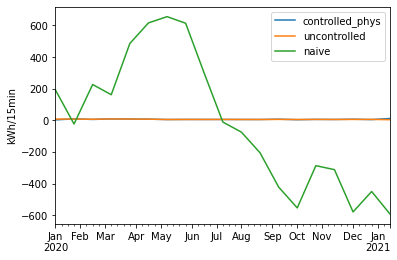

In [451]:
pd.concat([
    physical_controlled_DIS_CHARGE_aggregated, uncontrolled_DIS_CHARGE_aggregated, controlled_DIS_CHARGE_naive
          ], axis=1).resample("3w").mean().plot(ylabel="kWh/15min")

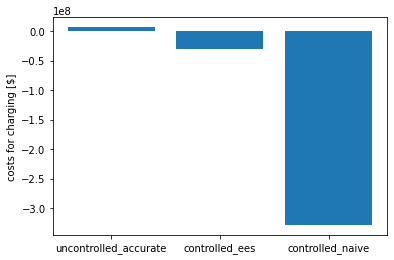

In [448]:
#costs
plt.bar(x = ["uncontrolled_accurate", "controlled_ees", "controlled_naive"],  height=[
    uncontrolled_costs, controlled_costs_ees, controlled_costs_naive
])
plt.ylabel("costs for charging [€/year]")
plt.show()

In [ ]:
#overestimation in % €
(controlled_costs_ees + controlled_costs_naive) / (-controlled_costs_naive)

## ∆system costs, in comparison to an energy system without the flexibility [€/a]
## VRE